In [88]:
import math
import numpy as np
import sys
import pandas as pd
from scipy import signal


df = pd.read_csv('atqa_manresa_smart_container.csv', skiprows=4)
import matplotlib.pyplot as plt

In [89]:
#%pip install numpy pandas matplotlib


In [90]:
import py4hw

In [91]:
#%pip install py4hw

In [92]:
#%pip install scipy


In [93]:
from scipy.signal import kaiserord, lfilter, firwin, freqz
# order/dectector/coefficient/freq

def highpass_filter(Fs, cutoff, db, ntaps, ripple_db):
    nyq_rate = Fs/2
    width = (0.1 * cutoff) 
    N, beta = kaiserord(db, width) #order/N:number of taps
    
    if (N > ntaps):
        print('WARNING: the kaiser window would require {} taps (more than the {} requested)'.format(N, ntaps))
    
    cutoff_hz = cutoff/nyq_rate #range of freq
    
    # Use firwin with a Kaiser window to create a lowpass FIR filter.
    taps = firwin(ntaps, cutoff_hz, window=('kaiser', beta), pass_zero='highpass')
    return taps

In [94]:
from scipy.signal import kaiserord, lfilter, firwin, freqz
# order/dectector/coefficient/freq

def lowpass_filter(Fs, cutoff, db, ntaps, ripple_db):
    nyq_rate = Fs/2
    width = (0.1 * cutoff) 
    N, beta = kaiserord(db, width) #order/N:number of taps
    
    if (N > ntaps):
        print('WARNING: the kaiser window would require {} taps (more than the {} requested)'.format(N, ntaps))
    
    cutoff_hz = cutoff/nyq_rate #range of freq
    
    # Use firwin with a Kaiser window to create a lowpass FIR filter.
    taps = firwin(ntaps, cutoff_hz, window=('kaiser', beta), pass_zero='lowpass')
    taps = taps / np.sum(taps)
    
    return taps

In [95]:
# Hardware multiplier of "r/each tap = input signal a × constant coefficients coeff"

class MultSignalByCoeff(py4hw.Logic):
    def __init__(self, parent, name, a, coeff, r):
        super().__init__(parent, name)
        
        self.addIn('a', a)
        self.addOut('r', r)
        
        w = a.getWidth()
        
        assert(w == r.getWidth())
        
        # inside signal
        sa = self.wire('sa', w) #The sign extension of a
        sr = self.wire('sr', 2*w) #multip result
        k = self.wire('k', w) #constant 2 w-1(index) 
        b = self.wire('b', w) 
        
        py4hw.Constant(self, 'k', 1<<(w-1), k) # w=16,k=1<<15=32768
        
        py4hw.Constant(self, 'coeff', int((1<<(w-1)) * coeff), b) #b = coeff × 2^(w−1)
        
        py4hw.SignedSub(self, 'sa', a, k, sa)
        py4hw.SignedMul(self, 'sr', sa, b, sr) #sr = sa(from a) × b(from coeff)
        
        py4hw.ShiftRightConstant(self, 'r', sr, w, r) #r = (a × coeff)

In [96]:
class highpassFilter(py4hw.Logic):
    def __init__(self, parent, name, Fs, cutoff, db, ntaps, x, r):
        super().__init__(parent, name)
        
        self.addIn('x', x)
        self.addOut('r', r)
        
        w = x.getWidth()
        z = [x]
        last = x
        
        # create the registers for z-1
        for i in range(ntaps-1):
            nwire = 'z_{}'.format(i+1)
            wire = self.wire(nwire, w)
            z.append(wire)
            py4hw.Reg(self, nwire, d=last, q=wire)
            last = wire
            
        taps = highpass_filter(Fs, cutoff, db, ntaps,db) #h[0], h[1], … h[N-1] FIR coeff
            
        for i in range(ntaps):
            pname = 'p{}'.format(i)
            p = self.wire(pname, w)
            
            MultSignalByCoeff(self, pname, z[i], taps[i], p) #p0 = z[0] × h[0]p0 = z[0] × h[0]... multi
            if (i == 0):
                last = p
            else:
                aname = 'a{}'.format(i)
                a = self.wire(aname, w)
                AddSignals(self, aname, p, last, a)
                last = a
                
        py4hw.Buf(self, 'buf', last, r) #r = Σ z[i] × h[i] plus

In [121]:
class lowpassFilter(py4hw.Logic):
    def __init__(self, parent, name, Fs, cutoff, db, ntaps, x, r):
        super().__init__(parent, name)
        
        self.addIn('x', x)
        self.addOut('r', r)
        
        w = x.getWidth()
        z = [x]
        last = x
        
        # create the registers for z-1
        for i in range(ntaps-1):
            nwire = 'z_{}'.format(i+1)
            wire = self.wire(nwire, w)
            z.append(wire)
            py4hw.Reg(self, nwire, d=last, q=wire)
            last = wire
            
        taps = lowpass_filter(Fs, cutoff, db, ntaps,db) #h[0], h[1], … h[N-1] FIR coeff
            
        for i in range(ntaps):
            pname = 'p{}'.format(i)
            p = self.wire(pname, w)
            
            MultSignalByCoeff(self, pname, z[i], taps[i], p) #p0 = z[0] × h[0]p0 = z[0] × h[0]... multi
            if (i == 0):
                last = p
            else:
                aname = 'a{}'.format(i)
                a = self.wire(aname, w)
                AddSignals(self, aname, p, last, a)
                last = a
                
        py4hw.Buf(self, 'buf', last, r) #r = Σ z[i] × h[i] plus

In [110]:
raw_data = df[' uart2nfca_system_top:u_uart2nfca_system|nfca_controller:u_nfca_controller|nfca_rx_dsp:u_nfca_rx_dsp|rx_raw_data']

print(raw_data[1])
def conv(s):
    try:
        v = int(s,2)
    except:
        v = 0
    return v
    
def to_signed(v, w=16):
    if v >= (1 << (w-1)):
        return v - (1 << w)
    return v

iraw_data = [to_signed(conv(x), 16) for x in raw_data[1:]]
rx = np.array(iraw_data, dtype=np.int32)


 100101010011


In [111]:
class Sequence(py4hw.Logic):
    def __init__(self, parent, name, data, r):
        super().__init__(parent, name)
        self.data = data
        self.idx = 0
        self.r = self.addOut('r', r)
        self.w = r.getWidth()
      
    def clock(self):
        self.bias = 1 << (self.w - 1)
        if self.idx < len(self.data):
            self.r.prepare(int(self.data[self.idx] + self.bias))
        else:
            self.r.prepare(0)
        self.idx += 1


In [112]:
class AddSignals(py4hw.Logic):
    def __init__(self, parent, name, a, b, r):
        super().__init__(parent, name)
        
        self.addIn('a', a)
        self.addIn('b', b)
        self.addOut('r', r)
        
        sa = self.wire('sa', a.getWidth())
        sb = self.wire('sb', b.getWidth())
        sr = self.wire('sr', r.getWidth())
        k = self.wire('k', r.getWidth())
        
        py4hw.Constant(self, 'k', 1<<15, k)
        
        py4hw.SignedSub(self, 'sa', a, k, sa)
        py4hw.SignedSub(self, 'sb', b, k, sb)
        
        py4hw.Add(self, 'sr', sa, sb, sr)
        py4hw.Add(self, 'r', sr, k, r)
        

In [113]:
#like SignalTap 
class StreamCapture(py4hw.Logic):
    def __init__(self, parent, name, x):
        super().__init__(parent, name)
        self.x = self.addIn('x', x)
        
        self.data = []
        
    def clock(self):
        self.data.append(self.x.get())

    def clear(self):
        self.data = []

class StreamCaptureSigned(py4hw.Logic):
    def __init__(self, parent, name, x):
        super().__init__(parent, name)
        self.x = self.addIn('x', x)
        
        self.data = []
        
    def clock(self):
        self.data.append(py4hw.IntegerHelper.c2_to_signed(self.x.get(), self.x.getWidth()))

    def clear(self):
        self.data = []        

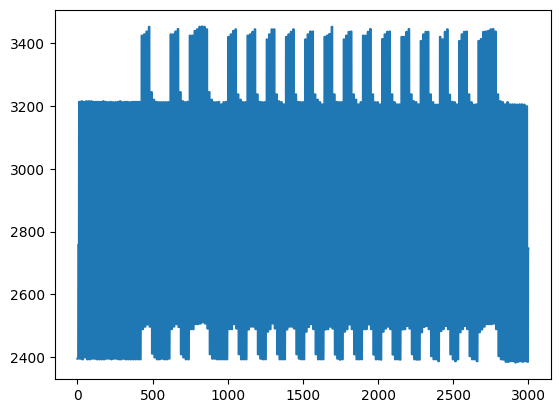

In [114]:
plt.plot(rx[2000:5000])
plt.show()

In [115]:
from py4hw import Logic
from py4hw import Wire
from py4hw import Sign, Neg, Mux2

In [116]:
class Abs(Logic):
    """
    Absolute value
    """
    def __init__(self, parent, name: str, a: Wire, r: Wire, inverted:Wire=None):
        """
        Creates ans absolute value circuit r = abs(a), inverted=sign(a)

        Parameters
        ----------
        parent : TYPE
            parent.
        name : str
            name.
        a : Wire
            input.
        r : Wire
            absolute value of a.
        inverted : Wire, optional
            indicates wether a was negated. The default is None.

        Returns
        -------
        None.

        """
        super().__init__(parent, name)
        self.a = self.addIn("a", a)
        self.r = self.addOut("r", r)

        if not(inverted is None):
            s = self.addOut('inverted', inverted)
        else:
            s = self.wire('sign')

        neg = self.wire('neg', a.getWidth())
        Sign(self, 'sign', a, s)
        Neg(self, 'neg', a, neg)
        Mux2(self, 'mux', s, a, neg, r)
        
    def structureName(self):
        if (self.a.getWidth() == self.r.getWidth()):
            return f'Abs{self.a.getWidth()}'
        else:
            return f'Abs{self.a.getWidth()}_{self.r.getWidth()}'


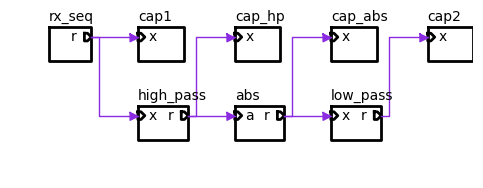

In [117]:
hw = py4hw.HWSystem()
hlp = py4hw.LogicHelper(hw)

dur = 0.001 #time
Fs = 13.56e6
freq1=847.5
amplitude = 0.5

x0 = hw.wire('x0', 16)
x = hw.wire('x', 16)

db = 60
ntaps = 31
Rb=106e3
cutoff= Rb*10

rx_w = hw.wire('rx_w', 16)
Sequence(hw, 'rx_seq', rx.astype(int), rx_w)

cap1 = StreamCapture(hw, 'cap1', rx_w) 
#rx_seq

hp = highpassFilter(hw, 'high_pass', Fs, cutoff, db, ntaps, rx_w, x)

cap_hp = StreamCaptureSigned(hw, 'cap_hp', x)
#after high_pass filter

abs_w = hw.wire('abs_w', 16)
abs1 = Abs(hw, 'abs', x, abs_w)

cap_abs = StreamCaptureSigned(hw, 'cap_abs', abs_w)

fc = 2*Rb    
lp_w = hw.wire('lp_w', 16)
lp = lowpassFilter(hw,'low_pass',Fs, fc, db, ntaps, abs_w, lp_w)

cap2 = StreamCaptureSigned(hw, 'cap2', lp_w)
#after abs+low_pass filter

#sch = py4hw.Schematic(hw)
sch = py4hw.Schematic(hw)
sch.drawAll()
#plt.savefig('topFIR.png')

In [118]:
hw.getSimulator().clk(2000)
cap1.clear()
cap_abs.clear()
cap_hp.clear()
cap2.clear()
hw.getSimulator().clk(5000-2000)
#print(rx_w.get())
#rx[:10].astype(int)

In [119]:
N = int(Fs * dur)
x = np.linspace(0, dur, N, endpoint=False)

y = np.array(cap1.data)
h_filtered=np.array(cap_hp.data)
abs_filtered=np.array(cap_abs.data)
filtered = np.array(cap2.data)
print(x.shape)

(13560,)


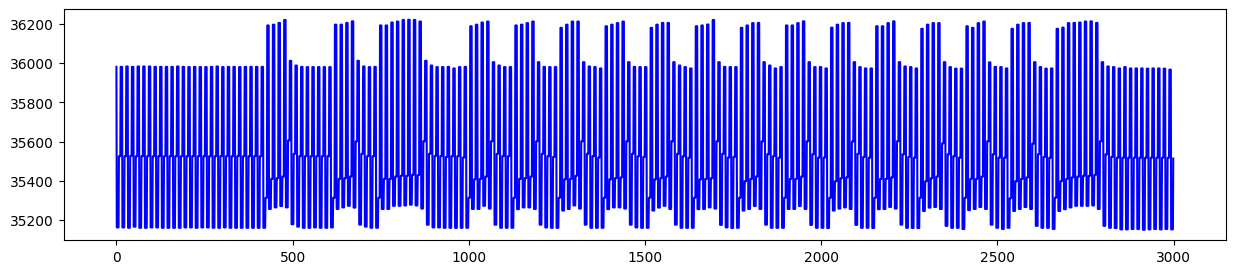

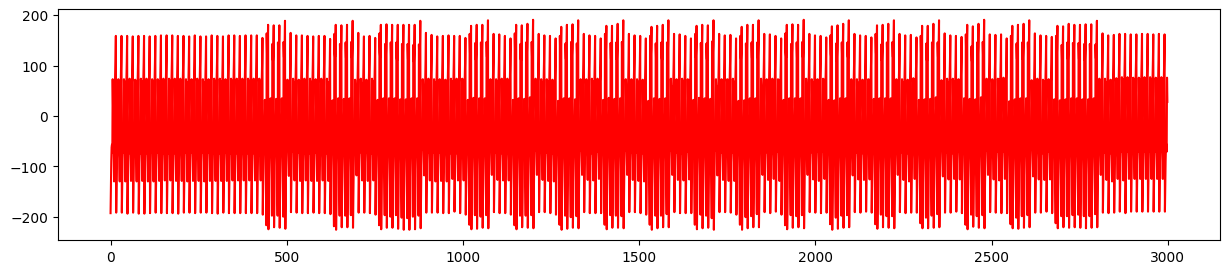

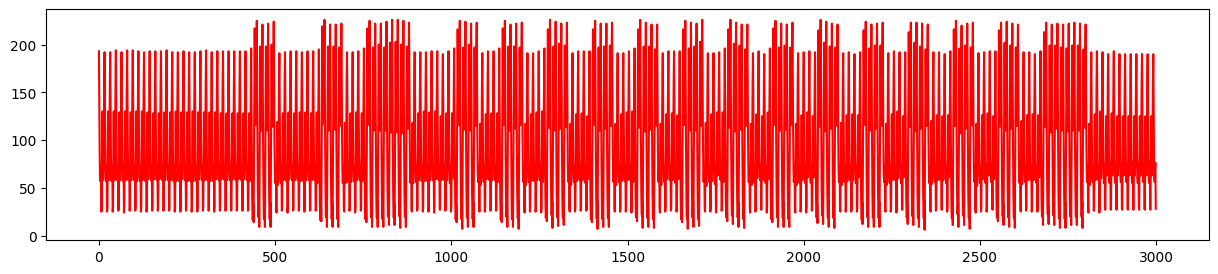

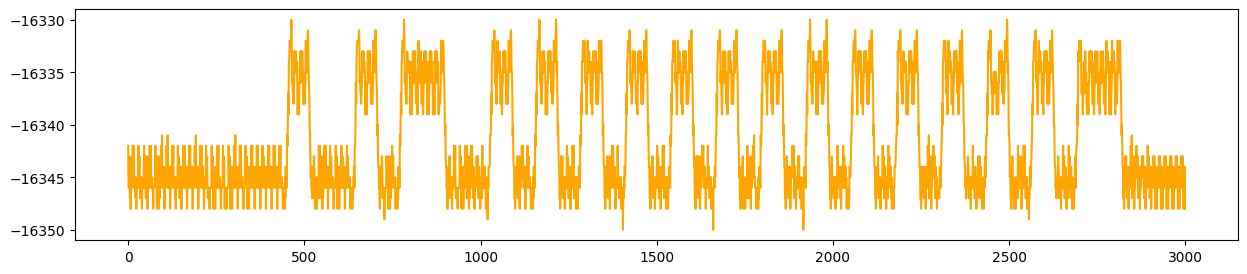

In [120]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.plot(y, color='blue')
#plt.ylim(30000, 1<<16)
#plt.savefig('filteredsignal.png')
plt.show()

plt.figure(figsize=(15,3))
plt.plot(h_filtered, color='red')
#plt.ylim(-1<<15, 1<<15)
#plt.savefig('filteredsignal.png')
plt.show()

plt.figure(figsize=(15,3))
plt.plot(abs_filtered, color='red')
#plt.ylim(-1<<15, 1<<15)
#plt.savefig('filteredsignal.png')
plt.show()

plt.figure(figsize=(15,3))
plt.plot(filtered, color='orange')
#plt.ylim(-1<<15, 1<<15)
#plt.savefig('filteredsignal.png')
plt.show()

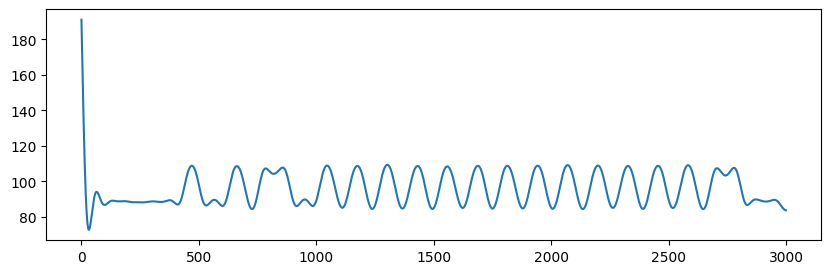

In [86]:
rectified = np.abs(h_filtered)
data=rx[2000:5000]
order = 5
nyquist = 0.5 * Fs
normal_cutoff =2*Rb / nyquist
b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
envelope = signal.filtfilt(b, a, rectified)
plt.figure(figsize=(10,3))
plt.plot(envelope)
plt.show()

109.33427697164296
84.37786138173777


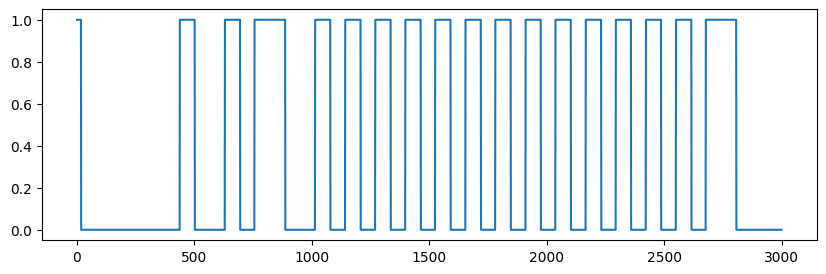

96.85606917669037


In [87]:
envelope_max = envelope[200:2800].max()
envelope_min = envelope[200:2800].min()
print(envelope_max)
print(envelope_min)

threshold = (envelope_max + envelope_min)/2
bit = (envelope > threshold).astype(int) 

plt.figure(figsize=(10,3))
plt.plot(bit)
plt.show()
print(threshold)